<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

# Explore our Data & Preprocess

In [2]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = "data/chest_xray/"

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

In [3]:
from PIL import Image

def detect_image_mode(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Check the number of channels
    num_channels = image.mode

    if num_channels == 'L':
        return "Black and White (Grayscale)"
    elif num_channels == 'RGB':
        return "Color (RGB)"
    else:
        return "Unknown"

# Example usage
image_path = r"data_color\chest_xray\train\NORMAL\IM-0115-0001.jpeg"
image_mode = detect_image_mode(image_path)
print(f"The image is in {image_mode} mode.")

The image is in Color (RGB) mode.


It seems that our images are actually greyscale meaning they have have 1 channel rather than 3 channels unlike RGB images. [reference pillow docs](https://pillow.readthedocs.io/en/stable/handbook/concepts.html)

In [4]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1080 normal images in the training set
There are 3107 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 269 normal images in the validation set
There are 776 pneumonia images in the validation set


Lets preprocess the images by resizing to (128, 128, 3)

In [5]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.


Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (128, 128, 3)


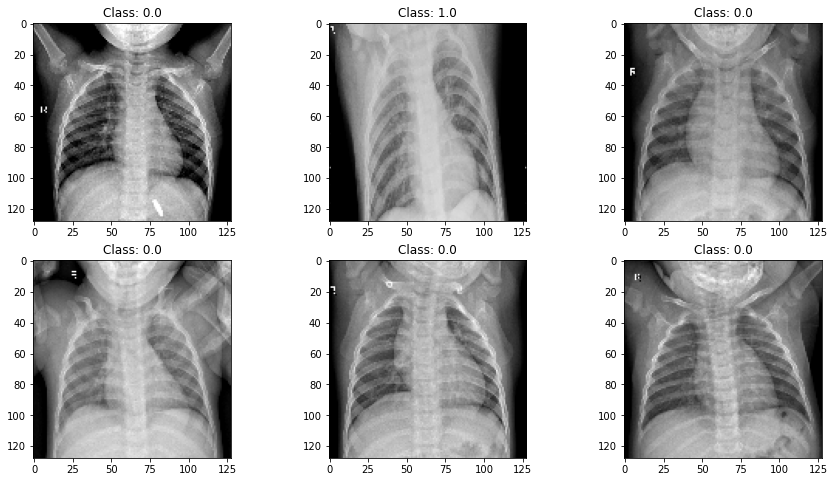

In [6]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

Image dimensions: (128, 128, 3)


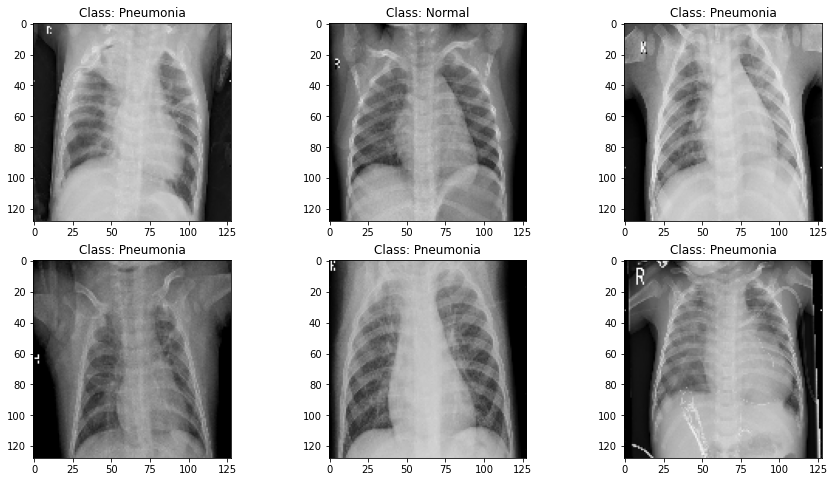

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

# Set the background color of the entire figure to white
fig.set_facecolor('white')
plt.show()


# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

## MLP Version 1

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
# Flatten layer to reshape the output
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(128, activation='relu'))

# Define the output 
model_mlp_base.add(Dense(1, activation='sigmoid'))


model_mlp_base.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 92s 702ms/step - loss: 1.1659 - precision: 0.8616 - recall: 0.8999 - accuracy: 0.8185 - val_loss: 0.2338 - val_precision: 0.9500 - val_recall: 0.9304 - val_accuracy: 0.9120
Epoch 2/30
131/131 [==============================] - 34s 258ms/step - loss: 0.2096 - precision: 0.9372 - recall: 0.9604 - accuracy: 0.9229 - val_loss: 0.1710 - val_precision: 0.9306 - val_recall: 0.9845 - val_accuracy: 0.9340
Epoch 3/30
131/131 [==============================] - 33s 251ms/step - loss: 0.1585 - precision: 0.9544 - recall: 0.9704 - accuracy: 0.9436 - val_loss: 0.1483 - val_precision: 0.9497 - val_recall: 0.9742 - val_accuracy: 0.9426
Epoch 4/30
131/131 [==============================] - 33s 253ms/step - loss: 0.1548 - precision: 0.9548 - recall: 0.9649 - accuracy: 0.9401 - val_loss: 0.1472 - val_precision: 0.9442 - val_recall: 0.9820 - val_accuracy: 0.9435
Epoch 5/30
131/131 [==============================] - 33s 251ms/step - loss: 0.1269 - precis

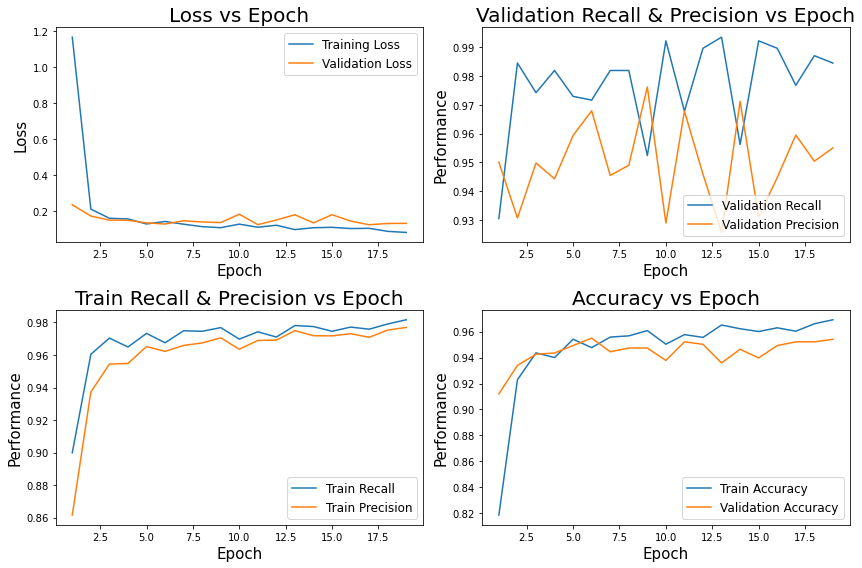

33/33 [==============================] - 6s 179ms/step - loss: 0.1229 - precision: 0.9678 - recall: 0.9678 - accuracy: 0.9522


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.092790,98.911250,96.491790,96.608549
1,Test,0.706620,74.081236,98.205125,77.403843
2,Validation,0.122911,96.778351,96.778351,95.215309


In [10]:
from functions import train_model, view_history, model_evaluate
mlp = {}

# Train the model
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=30)

# View History 
view_history(mlp, 'Version1')

# Evaluate model
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

It seems that we are generally still lowering both curves. We have slight overfit. Let reduce the neurons and we also need to lower learning rate since train loss in the beginning is high in comparison to val loss.

## MLP Version 2

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define learn rate
learning_rate = (0.001 + 0.0001)/2

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(128, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 35s 269ms/step - loss: 1.1656 - precision: 0.9097 - recall: 0.9160 - accuracy: 0.8498 - val_loss: 0.1664 - val_precision: 0.9349 - val_recall: 0.9807 - val_accuracy: 0.9349
Epoch 2/30
131/131 [==============================] - 34s 260ms/step - loss: 0.1951 - precision: 0.9465 - recall: 0.9562 - accuracy: 0.9274 - val_loss: 0.1560 - val_precision: 0.9556 - val_recall: 0.9716 - val_accuracy: 0.9455
Epoch 3/30
131/131 [==============================] - 34s 260ms/step - loss: 0.1675 - precision: 0.9585 - recall: 0.9591 - accuracy: 0.9389 - val_loss: 0.1768 - val_precision: 0.9797 - val_recall: 0.9317 - val_accuracy: 0.9349
Epoch 4/30
131/131 [==============================] - 34s 261ms/step - loss: 0.2198 - precision: 0.9489 - recall: 0.9511 - accuracy: 0.9257 - val_loss: 0.3931 - val_precision: 0.8885 - val_recall: 0.9961 - val_accuracy: 0.9043
Epoch 5/30
131/131 [==============================] - 34s 260ms/step - loss: 0.1859 - precis

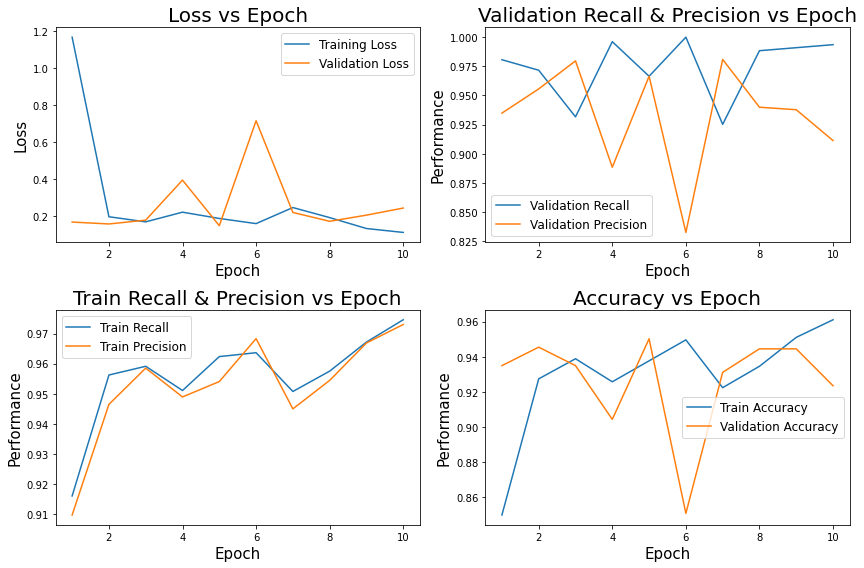

33/33 [==============================] - 6s 191ms/step - loss: 0.1560 - precision: 0.9556 - recall: 0.9716 - accuracy: 0.9455


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.121483,96.982342,97.232056,95.700979
1,Test,0.824116,73.091602,98.205125,76.282054
2,Validation,0.156037,95.564008,97.164947,94.545454


In [12]:
from functions import train_model, view_history, model_evaluate

# Update our dictionary with Version 2
mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=30)

# View History
view_history(mlp, 'Version2')

# Evaluate model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

## MLP Version 3

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(96, activation='relu'))

# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 96)                4718688   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 4,718,785
Trainable params: 4,718,785
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 34s 263ms/step - loss: 1.4018 - precision: 0.8752 - recall: 0.9092 - accuracy: 0.8364 - val_loss: 0.1998 - val_precision: 0.9508 - val_recall: 0.9459 - val_accuracy: 0.9234
Epoch 2/30
131/131 [==============================] - 34s 257ms/step - loss: 0.2193 - precision: 0.9357 - recall: 0.9549 - accuracy: 0.9178 - val_loss: 0.1683 - val_precision: 0.9263 - val_recall: 0.9884 - val_accuracy: 0.9330
Epoch 3/30
131/131 [==============================] - 34s 256ms/step - loss: 0.1629 - precision: 0.9527 - recall: 0.9665 - accuracy: 0.9396 - val_loss: 0.1425 - val_precision: 0.9666 - val_recall: 0.9691 - val_accuracy: 0.9522
Epoch 4/30
131/131 [==============================] - 34s 256ms/step - loss: 0.1431 - precision: 0.9552 - recall: 0.9672 - accuracy: 0.9420 - val_loss: 0.1512 - val_precision: 0.9375 - val_recall: 0.9858 - val_accuracy: 0.9407
Epoch 5/30
131/131 [==============================] - 34s 256ms/step - loss: 0.1374 - precis

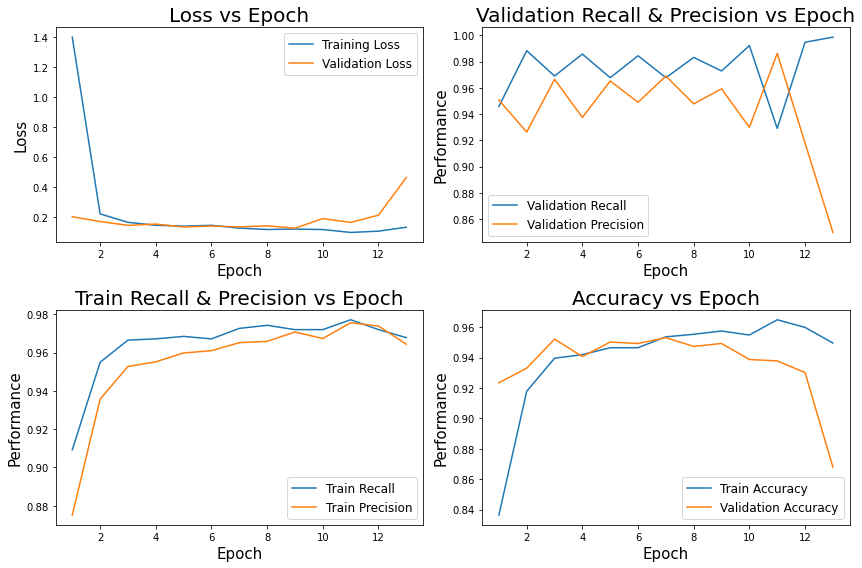

33/33 [==============================] - 6s 187ms/step - loss: 0.1320 - precision: 0.9653 - recall: 0.9678 - accuracy: 0.9502


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.105921,98.357427,96.363050,96.107000
1,Test,0.563933,75.294119,98.461539,78.846157
2,Validation,0.132019,96.529561,96.778351,95.023924


In [11]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

# View history
view_history(mlp, 'Version3')

# Evaluate model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

It still seems that we can generalize more. Both curves are still lowering and havent converged without diverging yet. Lets make the model deeper

## MLP Version 4

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(96, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                4718688   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,724,961
Trainable params: 4,724,961
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
131/131 [==============================] - 34s 262ms/step - loss: 0.7664 - precision: 0.8909 - recall: 0.9021 - accuracy: 0.8192 - val_loss: 0.1637 - val_precision: 0.9636 - val_recall: 0.9549 - val_accuracy: 0.9397
Epoch 2/20
131/131 [==============================] - 34s 257ms/step - loss: 0.2295 - precision: 0.9375 - recall: 0.9469 - accuracy: 0.9138 - val_loss: 0.4249 - val_precision: 0.9935 - val_recall: 0.7912 - val_accuracy: 0.8411
Epoch 3/20
131/131 [==============================] - 34s 260ms/step - loss: 0.2077 - precision: 0.9495 - recall: 0.9495 - accuracy: 0.9250 - val_loss: 0.1312 - val_precision: 0.9571 - val_recall: 0.9768 - val_accuracy: 0.9502
Epoch 4/20
131/131 [==============================] - 34s 260ms/step - loss: 0.1497 - precision: 0.9611 - recall: 0.9630 - accuracy: 0.9436 - val_loss: 0.1500 - val_precision: 0.9443 - val_recall: 0.9832 - val_accuracy: 0.9445
Epoch 5/20
131/131 [==============================] - 34s 260ms/step - loss: 0.1565 - precis

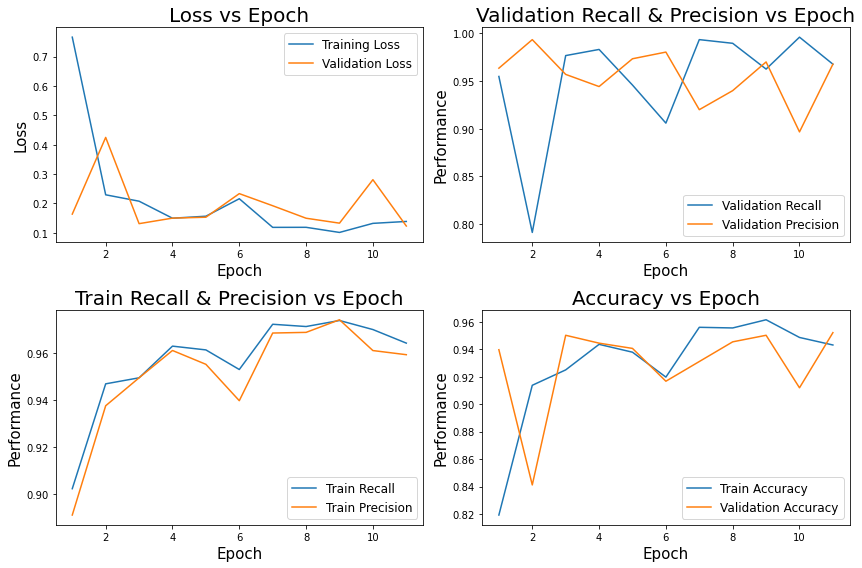

33/33 [==============================] - 6s 188ms/step - loss: 0.1312 - precision: 0.9571 - recall: 0.9768 - accuracy: 0.9502


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.108352,97.510505,97.071129,95.987582
1,Test,0.701858,73.282444,98.461539,76.602566
2,Validation,0.131184,95.707071,97.680414,95.023924


In [13]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=20)

# View history 
view_history(mlp, 'Version4')

# Evaluate model
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

It seems we keep doing better as the gaps are closing in on eachother. No overfit yet as our callback is ngating this from ocuring. Now make it wider again.

## MLP Version 5

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(96, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 96)                4718688   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,729,121
Trainable params: 4,729,121
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 35s 269ms/step - loss: 0.4293 - precision: 0.9027 - recall: 0.9274 - accuracy: 0.8524 - val_loss: 0.2208 - val_precision: 0.8955 - val_recall: 0.9936 - val_accuracy: 0.9091
Epoch 2/30
131/131 [==============================] - 34s 259ms/step - loss: 0.1912 - precision: 0.9454 - recall: 0.9585 - accuracy: 0.9281 - val_loss: 0.1996 - val_precision: 0.9779 - val_recall: 0.9111 - val_accuracy: 0.9187
Epoch 3/30
131/131 [==============================] - 33s 256ms/step - loss: 0.1571 - precision: 0.9546 - recall: 0.9604 - accuracy: 0.9367 - val_loss: 0.2186 - val_precision: 0.9123 - val_recall: 0.9923 - val_accuracy: 0.9234
Epoch 4/30
131/131 [==============================] - 33s 255ms/step - loss: 0.1739 - precision: 0.9513 - recall: 0.9614 - accuracy: 0.9348 - val_loss: 0.2308 - val_precision: 0.9844 - val_recall: 0.8943 - val_accuracy: 0.9110
Epoch 5/30
131/131 [==============================] - 33s 255ms/step - loss: 0.1889 - precis

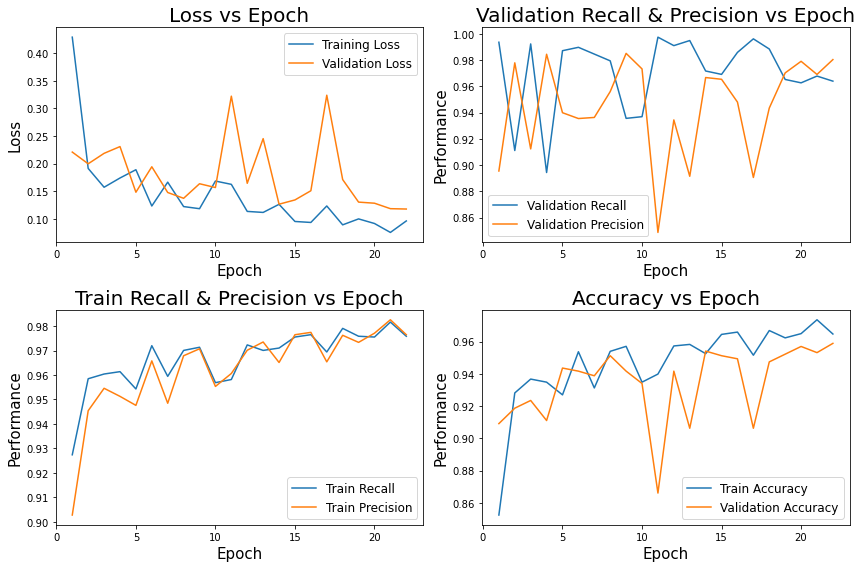

33/33 [==============================] - 6s 192ms/step - loss: 0.1263 - precision: 0.9667 - recall: 0.9716 - accuracy: 0.9541


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.078548,98.634589,97.650468,97.253406
1,Test,0.689888,74.468082,98.717946,78.044873
2,Validation,0.126325,96.666664,97.164947,95.406699


In [15]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=30)

# View history
view_history(mlp, 'Version5')

# Evaluate model 
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

We perform about the same in metrics but our loss curves seem much more better showing that adding another layer showed benefit in leanring. Now the gap between the curves is showing the captured noise rather than signal. Lets regularize the middle layer

## MLP Version 6

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(96, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model_mlp_base_6.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 96)                4718688   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,729,121
Trainable params: 4,729,121
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 34s 261ms/step - loss: 0.8951 - precision: 0.9006 - recall: 0.9243 - accuracy: 0.8467 - val_loss: 0.4884 - val_precision: 0.8934 - val_recall: 0.9936 - val_accuracy: 0.9072
Epoch 2/30
131/131 [==============================] - 33s 254ms/step - loss: 0.4883 - precision: 0.9260 - recall: 0.9382 - accuracy: 0.8985 - val_loss: 0.3778 - val_precision: 0.9338 - val_recall: 0.9820 - val_accuracy: 0.9349
Epoch 3/30
131/131 [==============================] - 33s 254ms/step - loss: 0.3376 - precision: 0.9559 - recall: 0.9630 - accuracy: 0.9396 - val_loss: 0.3437 - val_precision: 0.9798 - val_recall: 0.9369 - val_accuracy: 0.9388
Epoch 4/30
131/131 [==============================] - 33s 254ms/step - loss: 0.3513 - precision: 0.9522 - recall: 0.9543 - accuracy: 0.9305 - val_loss: 0.3384 - val_precision: 0.9243 - val_recall: 0.9910 - val_accuracy: 0.9330
Epoch 5/30
131/131 [==============================] - 33s 254ms/step - loss: 0.2828 - precis

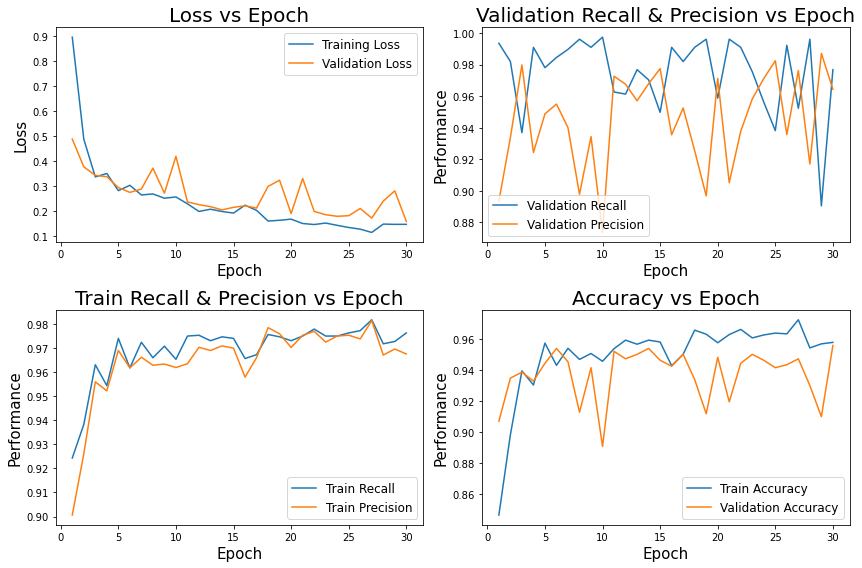

33/33 [==============================] - 6s 186ms/step - loss: 0.1603 - precision: 0.9644 - recall: 0.9768 - accuracy: 0.9560


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.090126,99.027550,98.326361,98.041558
1,Test,0.949823,73.613769,98.717946,77.083331
2,Validation,0.160295,96.437657,97.680414,95.598084


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=30)

# View history
view_history(mlp, 'Version6')

# Evaluate model 
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

It's a lot better but needs more regularization. 

## MLP Version 7

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(96, activation='relu'))
model_mlp_base_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
model_mlp_base_7.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 96)                4718688   
_________________________________________________________________
dense_14 (Dense)             (None, 64)                6208      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 4,729,121
Trainable params: 4,729,121
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 34s 261ms/step - loss: 4.6698 - precision: 0.8894 - recall: 0.9032 - accuracy: 0.8171 - val_loss: 2.1458 - val_precision: 0.9292 - val_recall: 0.9807 - val_accuracy: 0.9301
Epoch 2/30
131/131 [==============================] - 34s 256ms/step - loss: 1.6273 - precision: 0.9413 - recall: 0.9553 - accuracy: 0.9226 - val_loss: 1.2893 - val_precision: 0.9188 - val_recall: 0.9910 - val_accuracy: 0.9282
Epoch 3/30
131/131 [==============================] - 33s 256ms/step - loss: 1.1904 - precision: 0.9395 - recall: 0.9491 - accuracy: 0.9169 - val_loss: 1.1111 - val_precision: 0.8884 - val_recall: 0.9948 - val_accuracy: 0.9033
Epoch 4/30
131/131 [==============================] - 33s 255ms/step - loss: 0.9699 - precision: 0.9471 - recall: 0.9514 - accuracy: 0.9245 - val_loss: 0.9291 - val_precision: 0.8946 - val_recall: 0.9948 - val_accuracy: 0.9091
Epoch 5/30
131/131 [==============================] - 33s 255ms/step - loss: 0.7542 - precis

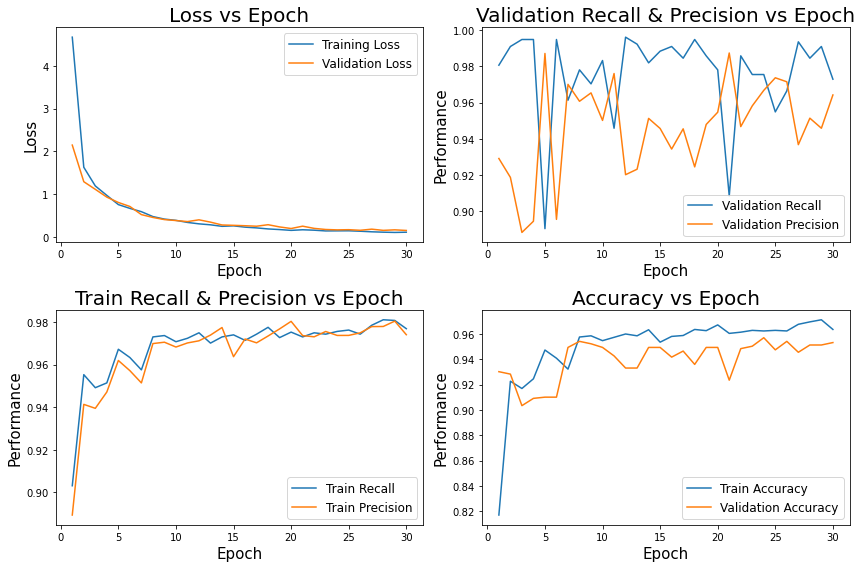

33/33 [==============================] - 6s 188ms/step - loss: 0.1494 - precision: 0.9642 - recall: 0.9729 - accuracy: 0.9531


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.074837,99.252278,98.261988,98.160976
1,Test,0.865219,73.754787,98.717946,77.243590
2,Validation,0.149369,96.424007,97.293812,95.311004


In [20]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=30)

# View history
view_history(mlp, 'Version7')

# Evaluate model 
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

This last version is very good. Lets save it and attempt augmentation

In [21]:
model_mlp_base_7.save('models/mlp7.keras')

## Data Augmentation MLP

In [9]:
from tensorflow.keras.models import load_model

mlp = load_model("models/mlp7.keras")

In [10]:
# Call data augmentation function
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Epoch 1/30
131/131 [==============================] - 44s 336ms/step - loss: 0.6011 - precision: 0.7427 - recall: 0.9932 - accuracy: 0.7397 - val_loss: 0.5669 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/30
131/131 [==============================] - 42s 323ms/step - loss: 0.5585 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.5592 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 3/30
131/131 [==============================] - 42s 321ms/step - loss: 0.5477 - precision: 0.7476 - recall: 0.9907 - accuracy: 0.7449 - val_loss: 0.5636 - val_precision: 0.7958 - val_recall: 0.8892 - val_accuracy: 0.7483
Epoch 4/30
131/131 [==============================] - 42s 321ms/step - loss: 0.5452 - precision: 0.7630 - recall: 0.9710 - accuracy: 0.7547 - val_loss: 0.5375 - val_precision: 0.7500 - val_recall: 0.9936 - val_accuracy: 0.7493
Epoch 5/30
131/131 [==============================] - 42s 320ms/step - loss: 0.5377 - precis

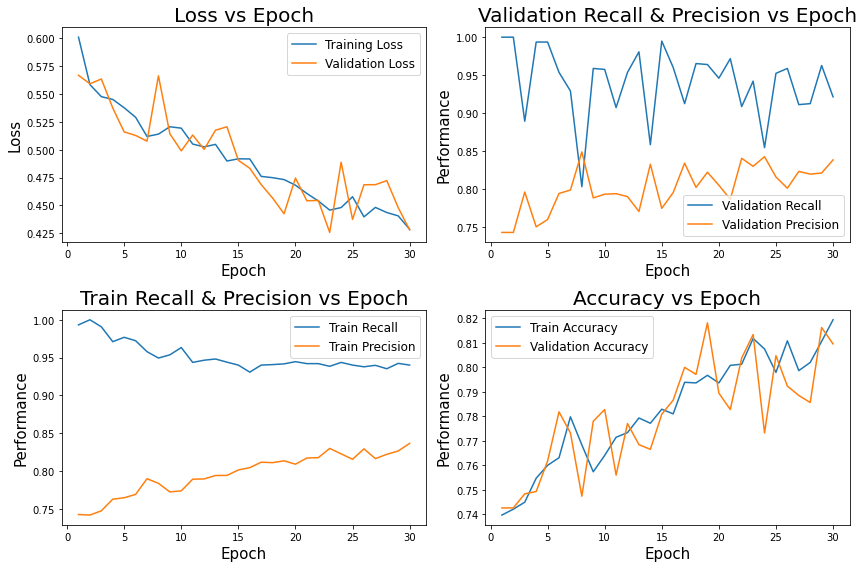

33/33 [==============================] - 8s 242ms/step - loss: 0.4314 - precision: 0.8377 - recall: 0.8982 - accuracy: 0.7952


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.434498,84.615386,91.342133,81.251490
1,Test,0.580983,67.522937,94.358975,68.108976
2,Validation,0.431358,83.774036,89.819586,79.521531


In [11]:
from functions import view_history, model_evaluate, train_model

# Train the model 
aug = {}

aug['Version1'] = train_model(mlp, train_gen_aug, val_gen_aug, 30)

# view history
view_history(aug, 'Version1')

# Evaluate model
model_evaluate(mlp, train_gen_aug, test_gen_aug, val_gen_aug)

In [14]:
mlp.save('models/mlp_aug.keras')

As expected we did not really do great in theory since our network is just a Dense network. It can not learn enought from the augmented images in comparison to Convolutional networks. The test set is not augmneted its just the regualr images. As we can see another trend is that we become very high on Recall/Sensitivity which is the True positive Rate. Of course the model leaned towards just learning when an image is a positive case since the dataset is very unbalanced leaning towrds Pneumoina images. Hope fully our Convolutional network can get Precision to increase in general.

# Convolutional Neural Network


## CNN Version 1

Generally ConV networks do better for image classification because they can exploit the spatial structure images thus obtaining more information. I do want to try our best dense network feature extraction from above but, before we add a conv layer to it lets make a baseline. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_1.add(MaxPool2D(pool_size=(2,2), padding="valid"))

# Define the Dense Layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 63504)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8128640   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,129,217
Trainable params: 8,129,217
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
131/131 [==============================] - 82s 627ms/step - loss: 0.7578 - precision: 0.7745 - recall: 0.9739 - accuracy: 0.7702 - val_loss: 0.3172 - val_precision: 0.9165 - val_recall: 0.9755 - val_accuracy: 0.9158
Epoch 2/30
131/131 [==============================] - 37s 286ms/step - loss: 0.2652 - precision: 0.9120 - recall: 0.9878 - accuracy: 0.9202 - val_loss: 0.3217 - val_precision: 0.8229 - val_recall: 1.0000 - val_accuracy: 0.8402
Epoch 3/30
131/131 [==============================] - 37s 281ms/step - loss: 0.2275 - precision: 0.9399 - recall: 0.9868 - accuracy: 0.9434 - val_loss: 0.2565 - val_precision: 0.8805 - val_recall: 0.9974 - val_accuracy: 0.8976
Epoch 4/30
131/131 [==============================] - 37s 286ms/step - loss: 0.2000 - precision: 0.9651 - recall: 0.9884 - accuracy: 0.9649 - val_loss: 0.2218 - val_precision: 0.8949 - val_recall: 0.9987 - val_accuracy: 0.9120
Epoch 5/30
131/131 [==============================] - 37s 281ms/step - loss: 0.1832 - precis

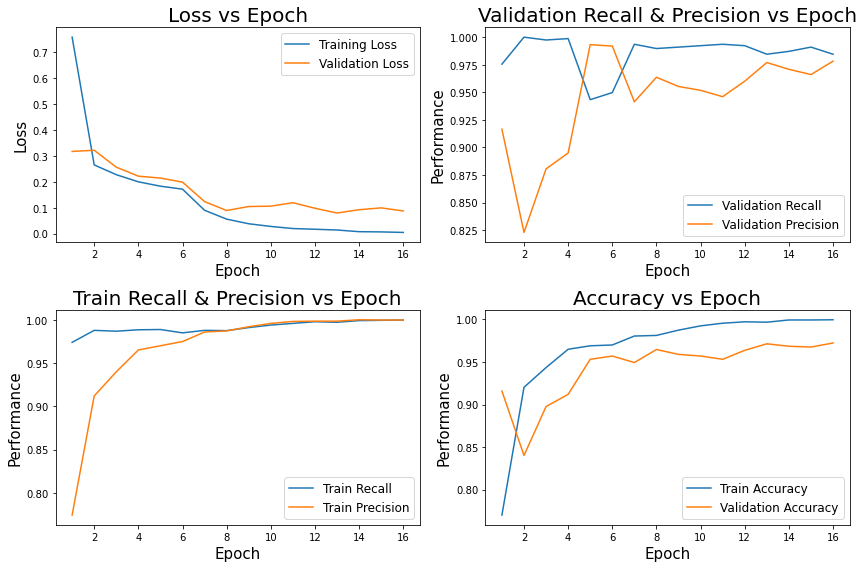

33/33 [==============================] - 6s 187ms/step - loss: 0.0893 - precision: 0.9636 - recall: 0.9897 - accuracy: 0.9646


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.037547,99.420100,99.324107,99.068546
1,Test,0.999275,70.727271,99.743587,74.038464
2,Validation,0.089343,96.361357,98.969072,96.459329


In [10]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train model
cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 30)

# View history 
view_history(cnn, 'Version1')

# Evalaute model
model_evaluate(cnn_1, train_gen, test_gen, val_gen)

Our model is generalizing well. It seems it has much more signal to learn since the region of 2-6 epochs does not have a nice curve. We can make the model more complex to attempt better generalization. That being said lets add a ConV layer on top of our best Dense network.

## CNN Version 2

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_2.add(MaxPool2D(pool_size=(2,2), padding="valid"))

# Define the Dense Layers
cnn_2.add(Flatten())
cnn_2.add(Dense(96, activation='relu'))
cnn_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
cnn_2.add(Dense(64, activation='relu'))

# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                6096480   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Epoch 1/30
131/131 [==============================] - 39s 295ms/step - loss: 3.8447 - precision: 0.9011 - recall: 0.9440 - accuracy: 0.8815 - val_loss: 1.4678 - val_precision: 0.9804 - val_recall: 0.9665 - val_accuracy: 0.9608
Epoch 2/30
131/131 [==============================] - 37s 285ms/step - loss: 0.8978 - precision: 0.9738 - recall: 0.9797 - accuracy: 0.9654 - val_loss: 0.6045 - val_precision: 0.9506 - val_recall: 0.9910 - val_accuracy: 0.9550
Epoch 3/30
131/131 [==============================] - 37s 284ms/step - loss: 0.4395 - precision: 0.9868 - recall: 0.9836 - accuracy: 0.9780 - val_loss: 0.3688 - val_precision: 0.9793 - val_recall: 0.9768 - val_accuracy: 0.9675
Epoch 4/30
131/131 [==============================] - 37s 284ms/step - loss: 0.2754 - precision: 0.9897 - recall: 0.9910 - accuracy: 0.9857 - val_loss: 0.2679 - val_precision: 0.9744 - val_recall: 0.9820 - val_accuracy: 0.9675
Epoch 5/30
131/131 [==============================] - 37s 284ms/step - loss: 0.1782 - precis

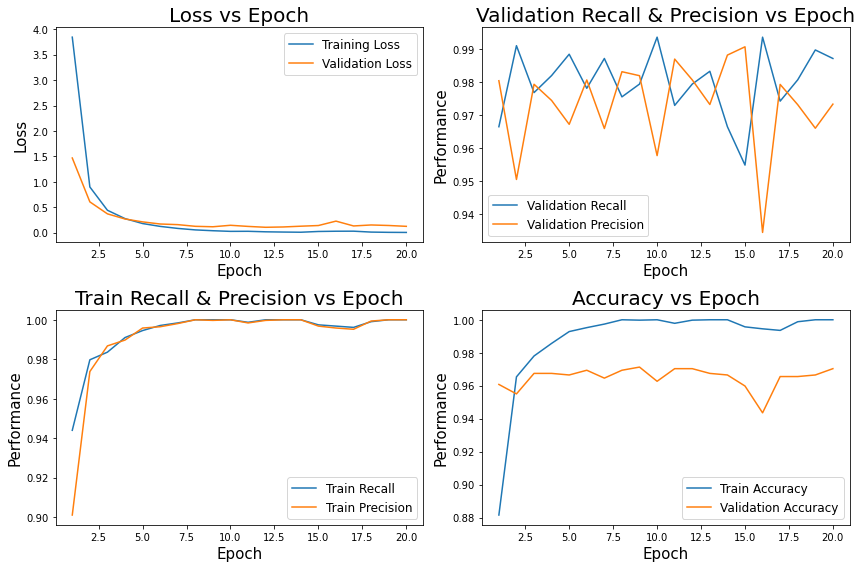

33/33 [==============================] - 6s 192ms/step - loss: 0.1046 - precision: 0.9806 - recall: 0.9794 - accuracy: 0.9703


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.013062,100.000000,100.000000,100.000000
1,Test,1.652313,72.118962,99.487180,75.641024
2,Validation,0.104630,98.064518,97.938144,97.033495


In [15]:
from functions import train_model, model_evaluate, view_history
cnn = {}

# Train the model
cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 30)

# View History 
view_history(cnn, "Version2")

# Evalauate Model
model_evaluate(cnn_2, train_gen, test_gen, val_gen)

Using the dense network from our previous work has some very slight overfit occuring. The gap is about a .1 difference. Both curves converged but none of the curves ended up diverging at all. Lets address the small ovefit we do see occuring. 

## CNN Version 3

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_3.add(MaxPool2D(pool_size=(2,2), padding="valid"))

# Define the Dense Layers
cnn_3.add(Flatten())
cnn_3.add(Dense(96, activation='relu'))
cnn_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.2)))
cnn_3.add(Dense(64, activation='relu'))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 96)                6096480   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

Epoch 1/30
131/131 [==============================] - 38s 293ms/step - loss: 7.2291 - precision: 0.9048 - recall: 0.9567 - accuracy: 0.8739 - val_loss: 2.2832 - val_precision: 0.9879 - val_recall: 0.9433 - val_accuracy: 0.9493
Epoch 2/30
131/131 [==============================] - 37s 286ms/step - loss: 1.1023 - precision: 0.9684 - recall: 0.9768 - accuracy: 0.9592 - val_loss: 0.5224 - val_precision: 0.9881 - val_recall: 0.9639 - val_accuracy: 0.9646
Epoch 3/30
131/131 [==============================] - 37s 285ms/step - loss: 0.3444 - precision: 0.9842 - recall: 0.9855 - accuracy: 0.9775 - val_loss: 0.2630 - val_precision: 0.9769 - val_recall: 0.9820 - val_accuracy: 0.9694
Epoch 4/30
131/131 [==============================] - 37s 285ms/step - loss: 0.2036 - precision: 0.9855 - recall: 0.9862 - accuracy: 0.9790 - val_loss: 0.1945 - val_precision: 0.9869 - val_recall: 0.9678 - val_accuracy: 0.9665
Epoch 5/30
131/131 [==============================] - 37s 285ms/step - loss: 0.1177 - precis

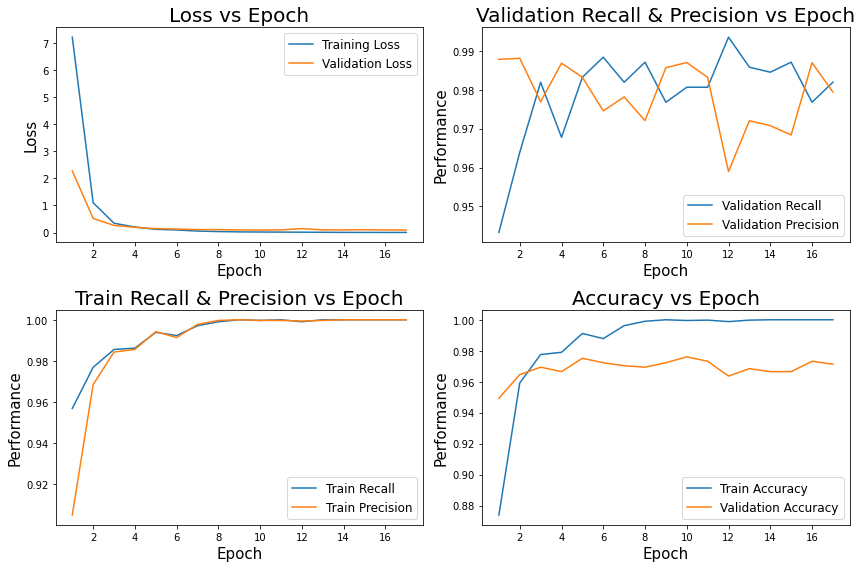

33/33 [==============================] - 6s 191ms/step - loss: 0.0978 - precision: 0.9857 - recall: 0.9768 - accuracy: 0.9722


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.020051,100.000000,100.000000,100.000000
1,Test,1.336096,71.851850,99.487180,75.320512
2,Validation,0.097796,98.569572,97.680414,97.224879


In [17]:
from functions import train_model, model_evaluate, view_history

# Train the model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 30)

# View History 
view_history(cnn, "Version3")

# Evalauate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

This is slightly better than before. 

In [18]:
cnn_3.save('models/cnn3.keras')

## CNN Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [19]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [20]:
from tensorflow.keras.models import load_model

cnn_aug = load_model("models/cnn3.keras")

In [21]:
from functions import model_evaluate, view_history, train_model
cnn_augmented = {}

# Train the model
cnn_augmented['Version1'] = train_model(cnn_aug, train_gen_aug, val_gen_aug, 30)

Epoch 1/30
131/131 [==============================] - 47s 357ms/step - loss: 0.5177 - precision: 0.8011 - recall: 0.9022 - accuracy: 0.7612 - val_loss: 0.4626 - val_precision: 0.7525 - val_recall: 0.9871 - val_accuracy: 0.7493
Epoch 2/30
131/131 [==============================] - 46s 352ms/step - loss: 0.4100 - precision: 0.8531 - recall: 0.8970 - accuracy: 0.8089 - val_loss: 0.3624 - val_precision: 0.9097 - val_recall: 0.8956 - val_accuracy: 0.8565
Epoch 3/30
131/131 [==============================] - 46s 351ms/step - loss: 0.3884 - precision: 0.8728 - recall: 0.8986 - accuracy: 0.8276 - val_loss: 0.3733 - val_precision: 0.8423 - val_recall: 0.9704 - val_accuracy: 0.8431
Epoch 4/30
131/131 [==============================] - 46s 351ms/step - loss: 0.3414 - precision: 0.8915 - recall: 0.9147 - accuracy: 0.8541 - val_loss: 0.3439 - val_precision: 0.9596 - val_recall: 0.8273 - val_accuracy: 0.8459
Epoch 5/30
131/131 [==============================] - 46s 351ms/step - loss: 0.3267 - precis

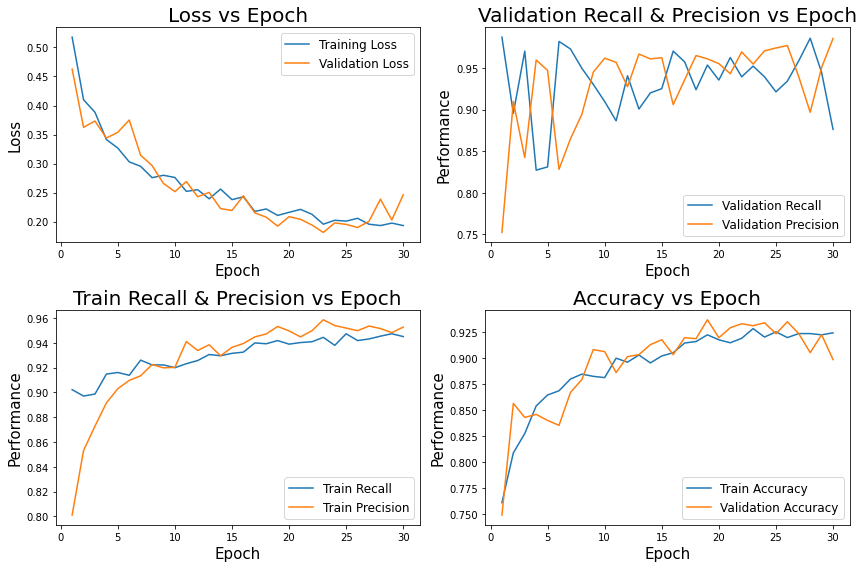

33/33 [==============================] - 8s 247ms/step - loss: 0.2170 - precision: 0.9886 - recall: 0.8905 - accuracy: 0.9110


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.228308,98.641402,88.799483,90.780991
1,Test,0.360676,88.433737,94.102561,88.621795
2,Validation,0.217044,98.855507,89.046389,91.100478


In [22]:
# Visualize history 
view_history(cnn_augmented, 'Version1')

# Evaluate model
model_evaluate(cnn_aug, train_gen_aug, test_gen_aug, val_gen_aug)

In [25]:
# Save our model from augmented training
cnn_aug.save("models/cnn_aug.keras")

Our losses in our test are much better. We even performed better by 18% in our Precision which is good news! As expected Recall stayed with high percentage since we have more positive instances in the dataset. Just for general understanding the test set is not augmented only the train and val sets which is why we see worse performance in comparison to test in Recall. 

The next step would be to take a pretrained architecture and attempt modeling this data rather than starting from scratch.

# Transfer Learning

## VGG19 Feature Extraction

Another method to use here would be to use an already pre trained network and see the results with our network. Lets use VGG19. To use it we need to process the data in a different way to be 224, 224, 3. 

In [9]:
from functions import process_data
# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [10]:
from keras.applications import VGG19
vgg19 = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128, 128, 3)
)

vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Lets Create a Feature Extraction function

In [11]:
from functions import process_data, extract_features_vgg19

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

train_features, train_labels, val_features, val_labels, test_features, test_labels = extract_features_vgg19(model=vgg19, train_gen=train_gen, val_gen=val_gen, test_gen=test_gen)

Found 4187 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [12]:
print("Shape of train_features:", train_features.shape)

Shape of train_features: (4187, 4, 4, 512)


### Version 1 Feature Extraction

In [13]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from functions import get_callbacks
import datetime

input_shape = (4, 4, 512)

model = models.Sequential()
# Flatten layer to convert the 4x4x512 tensor to a 1D tensor
model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)


start = datetime.datetime.now()

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_features, val_labels), 
                    callbacks=get_callbacks())

end = datetime.datetime.now()
traintime = end - start

print(f"Train time elapsed for {traintime}")

Epoch 1/30
131/131 [==============================] - 1s 8ms/step - loss: 0.2125 - precision: 0.9361 - recall: 0.9485 - accuracy: 0.9138 - val_loss: 0.0909 - val_precision: 0.9707 - val_recall: 0.9832 - val_accuracy: 0.9656
Epoch 2/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1056 - precision: 0.9717 - recall: 0.9720 - accuracy: 0.9582 - val_loss: 0.0822 - val_precision: 0.9746 - val_recall: 0.9884 - val_accuracy: 0.9722
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0588 - precision: 0.9861 - recall: 0.9833 - accuracy: 0.9773 - val_loss: 0.0893 - val_precision: 0.9651 - val_recall: 0.9974 - val_accuracy: 0.9713
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0455 - precision: 0.9897 - recall: 0.9868 - accuracy: 0.9826 - val_loss: 0.0731 - val_precision: 0.9758 - val_recall: 0.9871 - val_accuracy: 0.9722
Epoch 5/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0504 - precision: 0.9887 - r

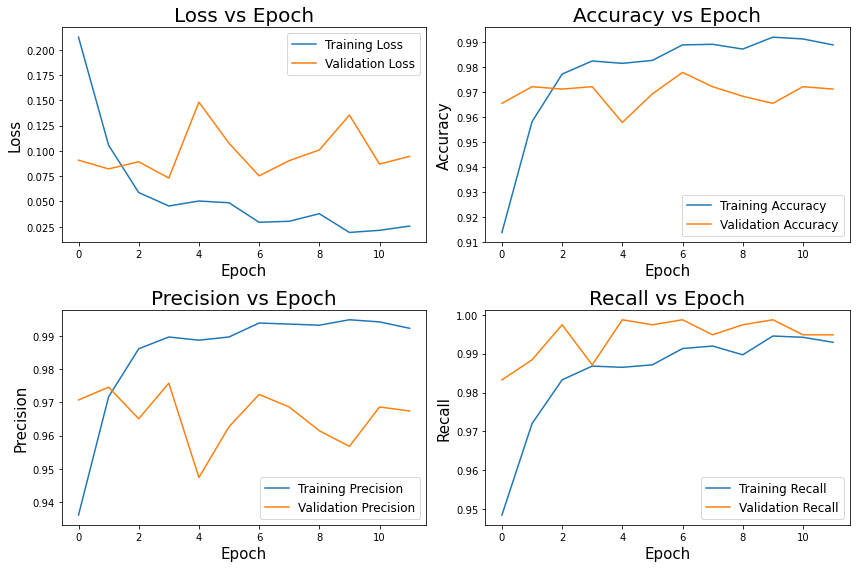

,Set,Loss,Accuracy,Precision,Recall
0,Train,0.026604,0.997086,0.997086,0.991310
1,Validation,0.073146,0.975796,0.975796,0.987113
2,Test,1.014643,0.728464,0.728464,0.997436


In [14]:
from functions import view_history_vgg19, evaluate_model
# View history
view_history_vgg19(history=history)

# Evaluate the model on all sets
evaluate_model(model, train_features, train_labels, val_features, val_labels, test_features, test_labels)

### Version 2 Feature Extraction

Its clear that we over fitted lets add a kernel regularizer to the 128 layer

In [15]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from functions import get_callbacks
from keras.regularizers import l2
import datetime

input_shape = (4, 4, 512)

model2 = models.Sequential()
# Flatten layer to convert the 4x4x512 tensor to a 1D tensor
model2.add(layers.Flatten(input_shape=input_shape))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=l2()))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)


start = datetime.datetime.now()

history2 = model2.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_features, val_labels), 
                    callbacks=get_callbacks())

end = datetime.datetime.now()
traintime = end - start

print(f"Train time elapsed for {traintime}")

Epoch 1/30
131/131 [==============================] - 1s 8ms/step - loss: 0.8510 - precision: 0.9147 - recall: 0.9634 - accuracy: 0.9293 - val_loss: 0.4093 - val_precision: 0.9128 - val_recall: 0.9987 - val_accuracy: 0.9282
Epoch 2/30
131/131 [==============================] - 1s 6ms/step - loss: 0.2697 - precision: 0.9730 - recall: 0.9746 - accuracy: 0.9611 - val_loss: 0.2013 - val_precision: 0.9746 - val_recall: 0.9871 - val_accuracy: 0.9713
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1617 - precision: 0.9852 - recall: 0.9826 - accuracy: 0.9761 - val_loss: 0.1612 - val_precision: 0.9686 - val_recall: 0.9948 - val_accuracy: 0.9722
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1134 - precision: 0.9897 - recall: 0.9903 - accuracy: 0.9852 - val_loss: 0.1370 - val_precision: 0.9921 - val_recall: 0.9716 - val_accuracy: 0.9732
Epoch 5/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0950 - precision: 0.9900 - r

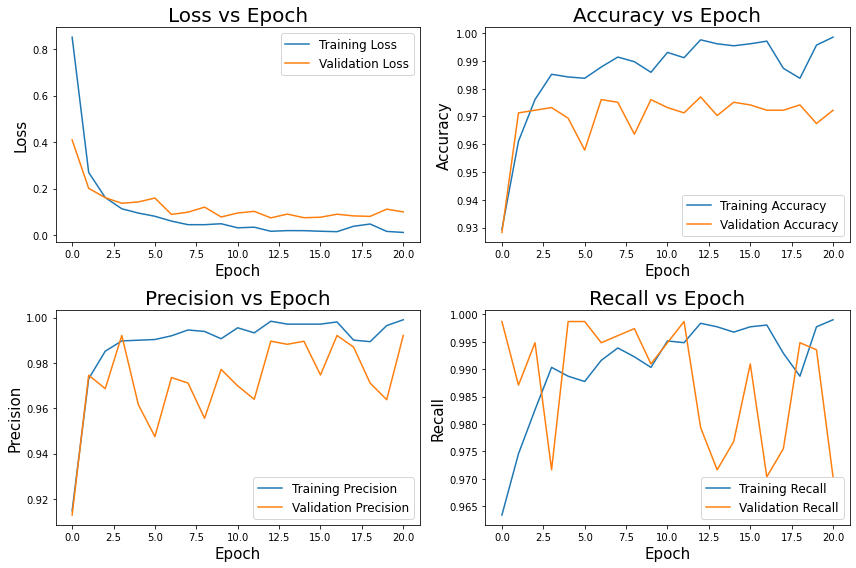

,Set,Loss,Accuracy,Precision,Recall
0,Train,0.015165,1.000000,1.000000,0.998391
1,Validation,0.074436,0.989583,0.989583,0.979381
2,Test,0.993027,0.765286,0.765286,0.994872


In [16]:
from functions import view_history_vgg19, evaluate_model
# View history
view_history_vgg19(history=history2)

# Evaluate the model on all sets
evaluate_model(model2, train_features, train_labels, val_features, val_labels, test_features, test_labels)

### Version 3 Feature Extraction

We are still overfitting but its much better. Lets increase the regularization

In [17]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from functions import get_callbacks
from keras.regularizers import l2
import datetime

input_shape = (4, 4, 512)

model3 = models.Sequential()
# Flatten layer to convert the 4x4x512 tensor to a 1D tensor
model3.add(layers.Flatten(input_shape=input_shape))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)

start = datetime.datetime.now()

history3 = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_features, val_labels), 
                    callbacks=get_callbacks())

end = datetime.datetime.now()
traintime = end - start

print(f"Train time elapsed for {traintime}")

Epoch 1/30
131/131 [==============================] - 1s 10ms/step - loss: 3.1951 - precision: 0.9104 - recall: 0.9505 - accuracy: 0.9095 - val_loss: 0.7753 - val_precision: 0.9731 - val_recall: 0.9807 - val_accuracy: 0.9656
Epoch 2/30
131/131 [==============================] - 1s 6ms/step - loss: 0.4633 - precision: 0.9736 - recall: 0.9736 - accuracy: 0.9608 - val_loss: 0.2824 - val_precision: 0.9673 - val_recall: 0.9910 - val_accuracy: 0.9684
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1968 - precision: 0.9823 - recall: 0.9826 - accuracy: 0.9740 - val_loss: 0.1635 - val_precision: 0.9710 - val_recall: 0.9936 - val_accuracy: 0.9732
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1110 - precision: 0.9897 - recall: 0.9887 - accuracy: 0.9840 - val_loss: 0.1145 - val_precision: 0.9870 - val_recall: 0.9755 - val_accuracy: 0.9722
Epoch 5/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0828 - precision: 0.9890 - 

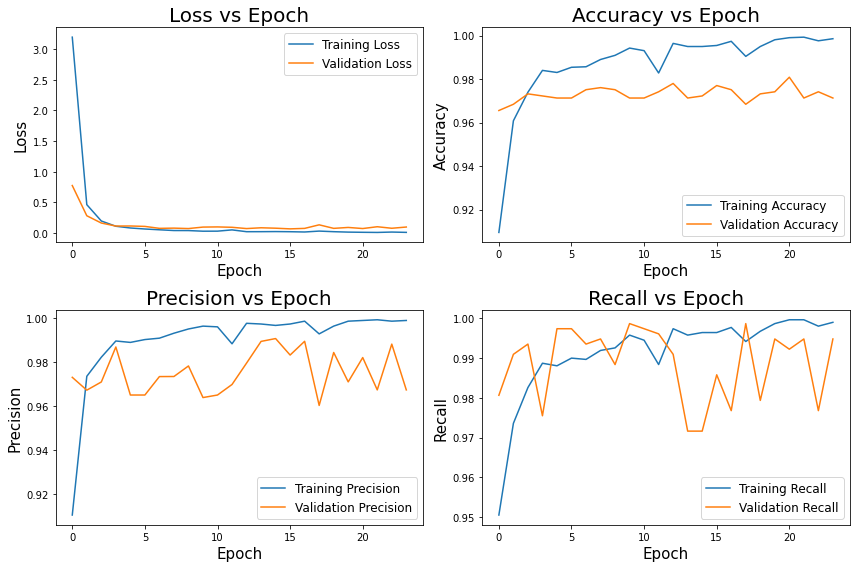

,Set,Loss,Accuracy,Precision,Recall
0,Train,0.013734,0.999678,0.999678,0.999678
1,Validation,0.068532,0.983290,0.983290,0.985825
2,Test,0.995097,0.752418,0.752418,0.997436


In [18]:
from functions import view_history_vgg19, evaluate_model
# View history
view_history_vgg19(history=history3)

# Evaluate the model on all sets
evaluate_model(model3, train_features, train_labels, val_features, val_labels, test_features, test_labels)

#### Version 4 Feature Extraction

Now the model no longer is overfitting. Lets attempt to make it deeper since our test metrics are still not improving in terms of Precision

In [19]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from functions import get_callbacks
import datetime
from keras.regularizers import l2


input_shape = (4, 4, 512)

model4 = models.Sequential()
# Flatten layer to convert the 4x4x512 tensor to a 1D tensor
model4.add(layers.Flatten(input_shape=input_shape))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model4.add(layers.Dense(128, activation='relu'))

model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)

history4 = model4.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_features, val_labels), 
                    callbacks=get_callbacks())

Epoch 1/30
131/131 [==============================] - 1s 8ms/step - loss: 2.9849 - precision: 0.9166 - recall: 0.9617 - accuracy: 0.9257 - val_loss: 0.6645 - val_precision: 0.9259 - val_recall: 0.9987 - val_accuracy: 0.9397
Epoch 2/30
131/131 [==============================] - 1s 7ms/step - loss: 0.3622 - precision: 0.9717 - recall: 0.9720 - accuracy: 0.9582 - val_loss: 0.2118 - val_precision: 0.9794 - val_recall: 0.9794 - val_accuracy: 0.9694
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1530 - precision: 0.9851 - recall: 0.9820 - accuracy: 0.9756 - val_loss: 0.1426 - val_precision: 0.9638 - val_recall: 0.9961 - val_accuracy: 0.9694
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0884 - precision: 0.9900 - recall: 0.9881 - accuracy: 0.9838 - val_loss: 0.0999 - val_precision: 0.9857 - val_recall: 0.9794 - val_accuracy: 0.9742
Epoch 5/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0718 - precision: 0.9884 - r

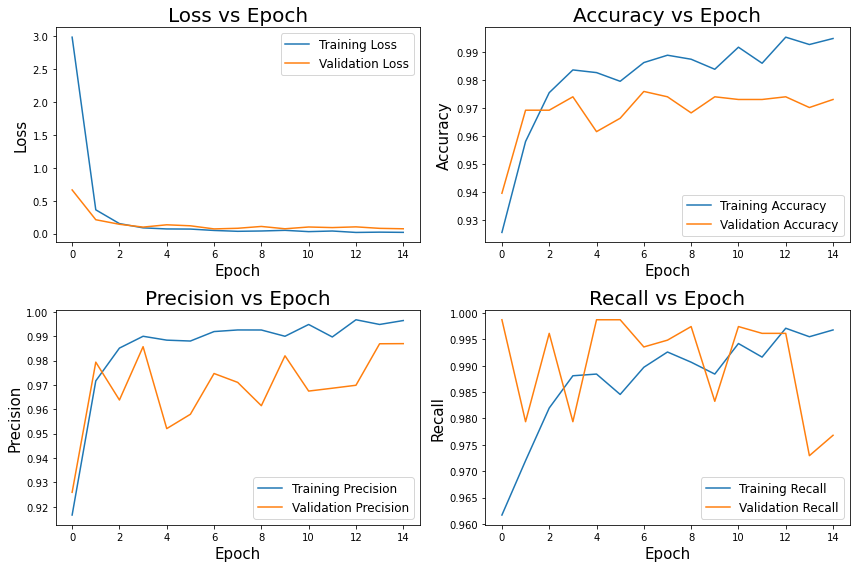

,Set,Loss,Accuracy,Precision,Recall
0,Train,0.029320,0.997102,0.997102,0.996781
1,Validation,0.072385,0.974716,0.974716,0.993557
2,Test,0.896388,0.731707,0.731707,1.000000


In [20]:
from functions import view_history_vgg19, evaluate_model
# View history
view_history_vgg19(history=history4)

# Evaluate the model on all sets
evaluate_model(model4, train_features, train_labels, val_features, val_labels, test_features, test_labels)

It had no impact on our test precision. Perhaps we need a wider layer

#### Version 5 Feature Extraction

In [21]:
from keras import models
from keras import layers
from keras.optimizers import Adam
from functions import get_callbacks


input_shape = (4, 4, 512)

model5 = models.Sequential()
# Flatten layer to convert the 4x4x512 tensor to a 1D tensor
model5.add(layers.Flatten(input_shape=input_shape))
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model5.add(layers.Dense(128, activation='relu'))

model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)

history5 = model5.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_features, val_labels), 
                    callbacks=get_callbacks())

Epoch 1/30
131/131 [==============================] - 1s 8ms/step - loss: 3.8455 - precision: 0.9152 - recall: 0.9565 - accuracy: 0.9238 - val_loss: 0.6560 - val_precision: 0.9054 - val_recall: 0.9987 - val_accuracy: 0.9215
Epoch 2/30
131/131 [==============================] - 1s 6ms/step - loss: 0.3189 - precision: 0.9752 - recall: 0.9746 - accuracy: 0.9627 - val_loss: 0.1812 - val_precision: 0.9832 - val_recall: 0.9781 - val_accuracy: 0.9713
Epoch 3/30
131/131 [==============================] - 1s 6ms/step - loss: 0.1289 - precision: 0.9855 - recall: 0.9820 - accuracy: 0.9759 - val_loss: 0.1227 - val_precision: 0.9662 - val_recall: 0.9948 - val_accuracy: 0.9703
Epoch 4/30
131/131 [==============================] - 1s 6ms/step - loss: 0.0773 - precision: 0.9887 - recall: 0.9887 - accuracy: 0.9833 - val_loss: 0.0909 - val_precision: 0.9857 - val_recall: 0.9781 - val_accuracy: 0.9732
Epoch 5/30
131/131 [==============================] - 1s 7ms/step - loss: 0.0644 - precision: 0.9894 - r

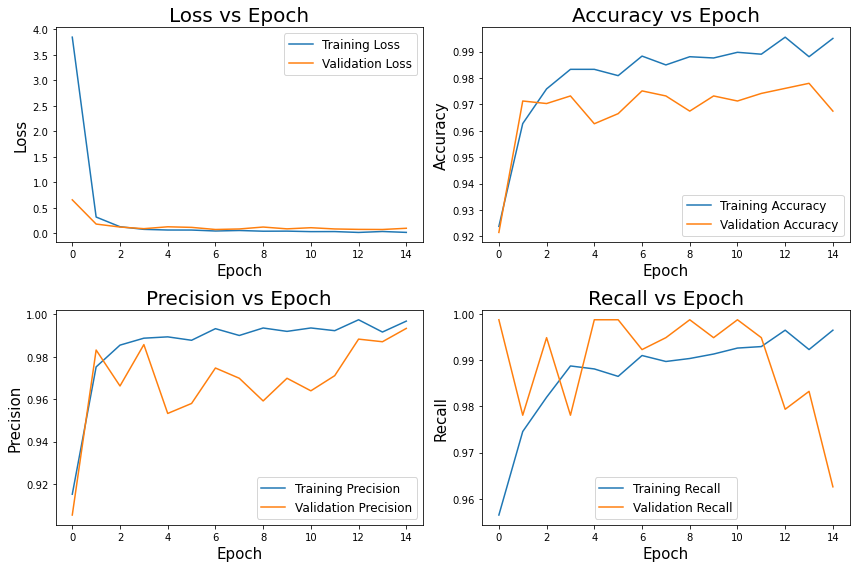

,Set,Loss,Accuracy,Precision,Recall
0,Train,0.025496,0.996781,0.996781,0.996781
1,Validation,0.074672,0.974684,0.974684,0.992268
2,Test,1.013777,0.724907,0.724907,1.000000


In [22]:
from functions import view_history_vgg19, evaluate_model
# View history
view_history_vgg19(history=history5)

# Evaluate the model on all sets
evaluate_model(model5, train_features, train_labels, val_features, val_labels, test_features, test_labels)

Its best to say no matter how wide or deep we go its not improving our generalization to unknown test data. We perfect the positive instance which makes sense because we have imbalanced data favoring Pneumonia.